### ATMS 597 Project 6 Group D



<b> Set Working Directory </b>

In [1]:
#YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project6/' # Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Project6/' # Michael
YOUR_DIRECTORY = './' # David

<b> Import libraries</b>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set(font_scale = 1.5)

## Data Processing

<b> Import Data </b>

In [3]:
gfs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

<b> Merge Datasets </b>

In [4]:
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

<b> Other stuff </b>

In [5]:
# Add year, month, day as integers
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

<b> Split </b>

In [6]:
# Tmax
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Tmin 
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Wind
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Precip
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Random Forest Regression

## Maximum Temperature

### Training Model

In [17]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

### RMSE

In [17]:
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


### Plot

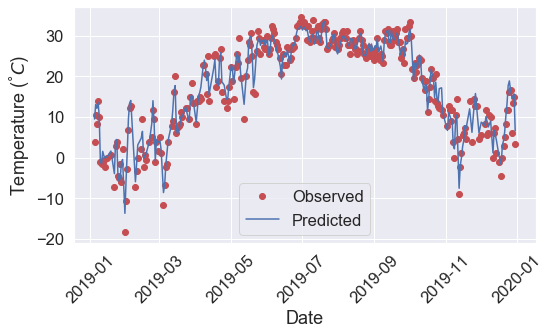

In [18]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

### Training Model

In [19]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

### RMSE

In [20]:
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


### Plot

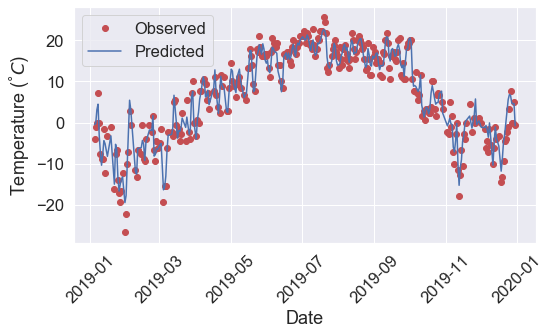

In [21]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Maximum Wind

### Training Model

In [22]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

### RMSE

In [23]:
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


### Plot

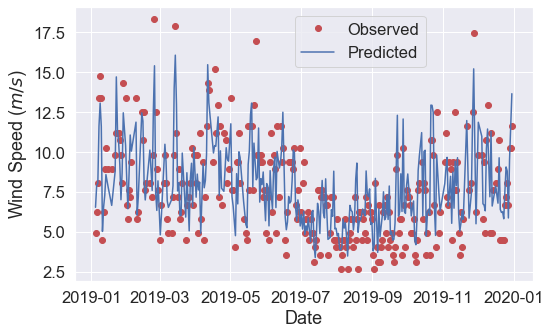

In [24]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Precipitation

### Training Model

In [25]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

### RMSE

In [26]:
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


### Plot

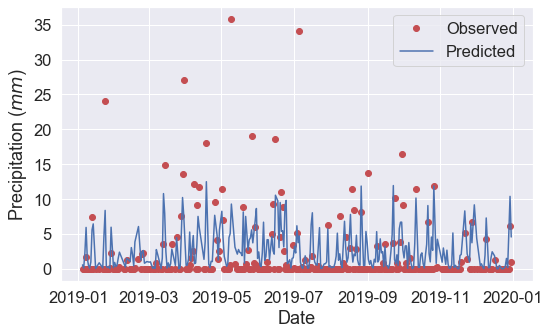

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Neural Network

<b> Import libraries </b>

In [7]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn import preprocessing

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import IPython

import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

print(tf.__version__)

2.0.0


<b> Useful functions </b>

In [35]:
def plot_history(unit):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [' + unit + ']')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

## Maximum Temperature

In [9]:
rf_train_vars_tmax.head()

,TMAX,TMIN,tmpc,dwpc,WMAX,day,Avg DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Avg HCLD(%),Avg PRES(hPa),Avg 850hPa DWPDEP(C),Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Min 850hPa WSPD(m/s)
0,-10.16,-15.96,-13.325000,-16.933333,4.687217,2,3.530000,4.95,36.000000,0.000000,1000.722222,15.539375,-14.439245,-19.584138,-15.991250,73.887425,13.817925
1,-9.96,-14.36,-16.525000,-19.816667,5.941380,3,3.194444,4.43,3.555556,7.375000,1000.677778,19.689315,-11.294434,-15.187083,-12.670853,28.958127,9.187170
2,-8.46,-12.86,-15.325000,-19.858333,5.685068,4,2.160000,3.11,37.777778,40.222222,998.111111,11.441479,-11.160000,-14.453023,-11.653750,11.908539,16.236038
3,-7.16,-11.06,-14.441667,-17.700000,3.794733,5,1.876667,2.37,96.555556,26.777778,996.388889,10.031624,-8.604550,-12.781705,-10.715814,9.865169,18.732500
4,-5.46,-7.46,-15.133333,-18.383333,9.548298,6,1.624444,2.39,77.125000,36.666667,994.244444,14.460429,-6.668571,-10.843721,-9.252248,46.999925,5.498429


In [10]:
# Standardize
rf_train_vars_tmax_norm = preprocessing.scale(rf_train_vars_tmax)

In [11]:
rf_train_vars_tmax_norm

array([[-2.32891796, -2.30849916, -2.27732287, ..., -2.76554373,
         1.07224601,  0.20569136],
       [-2.31115791, -2.14857422, -2.54522292, ..., -2.44072711,
        -0.60705908, -0.36187575],
       [-2.17795748, -1.9986446 , -2.4447604 , ..., -2.34122941,
        -1.24431497,  0.50206671],
       ...,
       [-0.23323133, -0.20948443, -0.73271164, ..., -0.54641769,
         1.19174789, -1.06252997],
       [-0.43747197, -0.70924984, -0.9141023 , ..., -0.10771683,
         0.90899938,  2.73577866],
       [-1.27219462, -0.97912316, -0.48295066, ..., -0.23558141,
         1.94153544,  0.83527197]])

### Build Model

In [135]:
# Build Model with 2 hidden layers of 64 neurons each
def build_tmax_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # There are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

In [136]:
tmax_model = build_tmax_model()

In [137]:
tmax_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 21        
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [140]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = tmax_model.fit(rf_train_vars_tmax_norm, train_verification_tmax, epochs=100, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 5s 2ms/sample - loss: 393.1646 - mae: 17.2847 - mse: 393.1647 - val_loss: 376.3895 - val_mae: 17.0448 - val_mse: 376.3895
Epoch 2/100
2631/2631 [==============================] - 1s 280us/sample - loss: 314.2260 - mae: 15.5937 - mse: 314.2259 - val_loss: 274.7274 - val_mae: 14.7755 - val_mse: 274.7273
Epoch 3/100
2631/2631 [==============================] - 1s 333us/sample - loss: 221.8383 - mae: 13.2901 - mse: 221.8383 - val_loss: 164.1875 - val_mae: 11.6521 - val_mse: 164.1875
Epoch 4/100
2631/2631 [==============================] - 1s 350us/sample - loss: 131.6871 - mae: 10.2479 - mse: 131.6871 - val_loss: 77.0144 - val_mae: 7.7578 - val_mse: 77.0144
Epoch 5/100
2631/2631 [==============================] - 1s 316us/sample - loss: 72.6254 - mae: 7.1714 - mse: 72.6254 - val_loss: 44.6540 - val_mae: 5.4282 - val_mse: 44.6540
Epoch 6/100
2631/2631 [==============================] - 1s

### RMSE

In [141]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.098


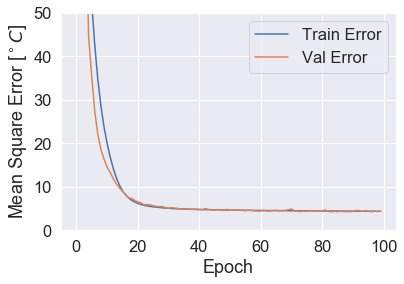

In [142]:
plot_history('$^\circ C$')

In [143]:
rf_test_vars_tmax_norm = preprocessing.scale(rf_test_vars_tmax)
tmax_rmse = mean_squared_error(test_verification_tmax, tmax_model.predict(rf_test_vars_tmax_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(tmax_rmse, 3)))

Root Mean Square Error on test set: 1.907


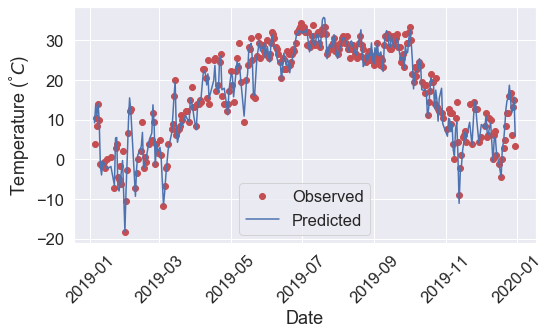

In [144]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, tmax_model.predict(rf_test_vars_tmax_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

In [10]:
rf_train_vars_tmin.head()

,TMAX,TMIN,WMAX,RTOT,mslp,wspd,skct,tmpc,dwpc,pr1h,...,Max PRES(hPa),Avg 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 250hPa HGT(m),Avg 500hPa HGT(m),Min 850hPa TMPC,Min 925hPa TMPC,Min 250hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s)
0,-10.16,-15.96,4.687217,0.00,1029.316667,5.591667,2.250000,-13.325000,-16.933333,0.000000,...,1002.0,15.539375,22.891972,10084.972389,5400.731226,-16.522911,-19.584138,73.887425,8.720833,28.288681
1,-9.96,-14.36,5.941380,0.06,1032.991667,4.633333,0.000000,-16.525000,-19.816667,0.000000,...,1001.8,19.689315,23.341408,10056.572290,5427.586216,-14.410704,-15.187083,28.958127,4.890000,14.984583
2,-8.46,-12.86,5.685068,0.17,1032.250000,3.641667,0.000000,-15.325000,-19.858333,0.000000,...,999.8,11.441479,17.652075,10010.796815,5392.037634,-11.718768,-14.453023,11.908539,15.286250,22.735308
3,-7.16,-11.06,3.794733,0.77,1028.141667,6.300000,1.333333,-14.441667,-17.700000,0.000000,...,997.3,10.031624,24.929242,10037.582053,5414.556603,-10.760000,-12.781705,9.865169,14.371860,20.754109
4,-5.46,-7.46,9.548298,7.10,1026.608333,5.191667,3.333333,-15.133333,-18.383333,-0.008333,...,996.0,14.460429,25.413714,10090.764166,5440.982389,-10.569524,-10.843721,46.999925,4.237442,14.102946


In [11]:
# Standardize
rf_train_vars_tmin_norm = preprocessing.scale(rf_train_vars_tmin)

In [12]:
rf_train_vars_tmin_norm

array([[-2.32891796, -2.30849916, -0.44270535, ...,  1.07224601,
        -0.33674362,  0.11453742],
       [-2.31115791, -2.14857422,  0.09056833, ..., -0.60705908,
        -0.84706671, -1.09184857],
       [-2.17795748, -1.9986446 , -0.01841627, ..., -1.24431497,
         0.53786603, -0.38903009],
       ...,
       [-0.23323133, -0.20948443,  1.93890825, ...,  1.19174789,
        -0.47028058,  1.00188642],
       [-0.43747197, -0.70924984,  0.96191022, ...,  0.90899938,
         3.41007599,  1.6955108 ],
       [-1.27219462, -0.97912316, -0.3092839 , ...,  1.94153544,
         0.85014981,  0.58586856]])

### Model

In [13]:
# Build verySimple model: with 1 hidden layer of 4 neurons
def build_tmin_model_verySimple():
    model = keras.Sequential([
        Dense(4, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

# Build Simple model: 1 hidden layer of 20 neurons
def build_tmin_model_Simple():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

# Build Intermediate model: 2 hidden layers of 20 neurons each
def build_tmin_model_Intermediate():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

# Build Complex model: 2 hidden layers of 64 neurons each
def build_tmin_model_Complex():
    model = keras.Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(64, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [14]:
tmin_model_verySimple = build_tmin_model_verySimple()
tmin_model_Simple = build_tmin_model_Simple()
tmin_model_Intermediate = build_tmin_model_Intermediate()
tmin_model_Complex = build_tmin_model_Complex()

In [16]:
[tmin_model_verySimple.summary(), tmin_model_Simple.summary(), tmin_model_Intermediate.summary(), tmin_model_Complex.summary()]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                560       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
________________

[None, None, None, None]

In [17]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

verySimple_history = tmin_model_verySimple.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
verySimplehist = pd.DataFrame(verySimple_history.history)
verySimplehist['epoch'] = verySimple_history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 6s 2ms/sample - loss: 148.5532 - mae: 10.1516 - mse: 148.5532 - val_loss: 164.9011 - val_mae: 10.6906 - val_mse: 164.9011
Epoch 2/100
2631/2631 [==============================] - 1s 367us/sample - loss: 132.0094 - mae: 9.4956 - mse: 132.0094 - val_loss: 146.8814 - val_mae: 10.0583 - val_mse: 146.8814
Epoch 3/100
2631/2631 [==============================] - 1s 251us/sample - loss: 116.2259 - mae: 8.8937 - mse: 116.2259 - val_loss: 128.5959 - val_mae: 9.4313 - val_mse: 128.5959
Epoch 4/100
2631/2631 [==============================] - 1s 295us/sample - loss: 101.0338 - mae: 8.3263 - mse: 101.0338 - val_loss: 109.7265 - val_mae: 8.7545 - val_mse: 109.7265
Epoch 5/100
2631/2631 [==============================] - 1s 292us/sample - loss: 86.2406 - mae: 7.7445 - mse: 86.2406 - val_loss: 90.4319 - val_mae: 7.9954 - val_mse: 90.4319
Epoch 6/100
2631/2631 [==============================] - 1s 2

In [18]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

Simple_history = tmin_model_Simple.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
Simplehist = pd.DataFrame(Simple_history.history)
Simplehist['epoch'] = Simple_history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 5s 2ms/sample - loss: 104.0090 - mae: 8.5039 - mse: 104.0090 - val_loss: 82.6213 - val_mae: 7.6355 - val_mse: 82.6212
Epoch 2/100
2631/2631 [==============================] - 1s 344us/sample - loss: 48.4852 - mae: 5.7987 - mse: 48.4852 - val_loss: 27.4742 - val_mae: 4.3717 - val_mse: 27.4742
Epoch 3/100
2631/2631 [==============================] - 1s 313us/sample - loss: 18.4594 - mae: 3.4439 - mse: 18.4594 - val_loss: 12.1518 - val_mae: 2.7942 - val_mse: 12.1518
Epoch 4/100
2631/2631 [==============================] - 1s 345us/sample - loss: 11.7124 - mae: 2.7044 - mse: 11.7125 - val_loss: 9.0480 - val_mae: 2.4277 - val_mse: 9.0480
Epoch 5/100
2631/2631 [==============================] - 1s 313us/sample - loss: 8.9696 - mae: 2.3537 - mse: 8.9696 - val_loss: 7.2620 - val_mae: 2.1589 - val_mse: 7.2620
Epoch 6/100
2631/2631 [==============================] - 1s 298us/sample - loss: 7.3

In [19]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

Intermediate_history = tmin_model_Intermediate.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
Intermediatehist = pd.DataFrame(Intermediate_history.history)
Intermediatehist['epoch'] = Intermediate_history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 6s 2ms/sample - loss: 113.8468 - mae: 8.9299 - mse: 113.8468 - val_loss: 66.4169 - val_mae: 6.9813 - val_mse: 66.4169
Epoch 2/100
2631/2631 [==============================] - 1s 270us/sample - loss: 29.9630 - mae: 4.2953 - mse: 29.9630 - val_loss: 11.3548 - val_mae: 2.6400 - val_mse: 11.3548
Epoch 3/100
2631/2631 [==============================] - 1s 276us/sample - loss: 9.9977 - mae: 2.4455 - mse: 9.9977 - val_loss: 7.7882 - val_mae: 2.2076 - val_mse: 7.7882
Epoch 4/100
2631/2631 [==============================] - 1s 303us/sample - loss: 7.4153 - mae: 2.1163 - mse: 7.4153 - val_loss: 6.3934 - val_mae: 1.9281 - val_mse: 6.3934
Epoch 5/100
2631/2631 [==============================] - 1s 295us/sample - loss: 6.3999 - mae: 1.9587 - mse: 6.3999 - val_loss: 5.4721 - val_mae: 1.7806 - val_mse: 5.4721
Epoch 6/100
2631/2631 [==============================] - 1s 298us/sample - loss: 5.8297 - 

In [20]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

Complex_history = tmin_model_Complex.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
Complexhist = pd.DataFrame(Complex_history.history)
Complexhist['epoch'] = Complex_history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 7s 3ms/sample - loss: 45.2948 - mae: 4.9034 - mse: 45.2948 - val_loss: 7.4214 - val_mae: 2.1596 - val_mse: 7.4214
Epoch 2/100
2631/2631 [==============================] - 2s 661us/sample - loss: 6.5807 - mae: 2.0048 - mse: 6.5807 - val_loss: 5.6789 - val_mae: 1.8599 - val_mse: 5.6789
Epoch 3/100
2631/2631 [==============================] - 1s 420us/sample - loss: 5.3148 - mae: 1.8013 - mse: 5.3148 - val_loss: 4.6033 - val_mae: 1.6509 - val_mse: 4.6033
Epoch 4/100
2631/2631 [==============================] - 1s 382us/sample - loss: 4.7732 - mae: 1.7168 - mse: 4.7732 - val_loss: 4.3090 - val_mae: 1.5504 - val_mse: 4.3090
Epoch 5/100
2631/2631 [==============================] - 1s 371us/sample - loss: 4.4615 - mae: 1.6546 - mse: 4.4615 - val_loss: 4.9483 - val_mae: 1.6466 - val_mse: 4.9483
Epoch 6/100
2631/2631 [==============================] - 1s 441us/sample - loss: 4.2554 - mae: 1.6

### Histories

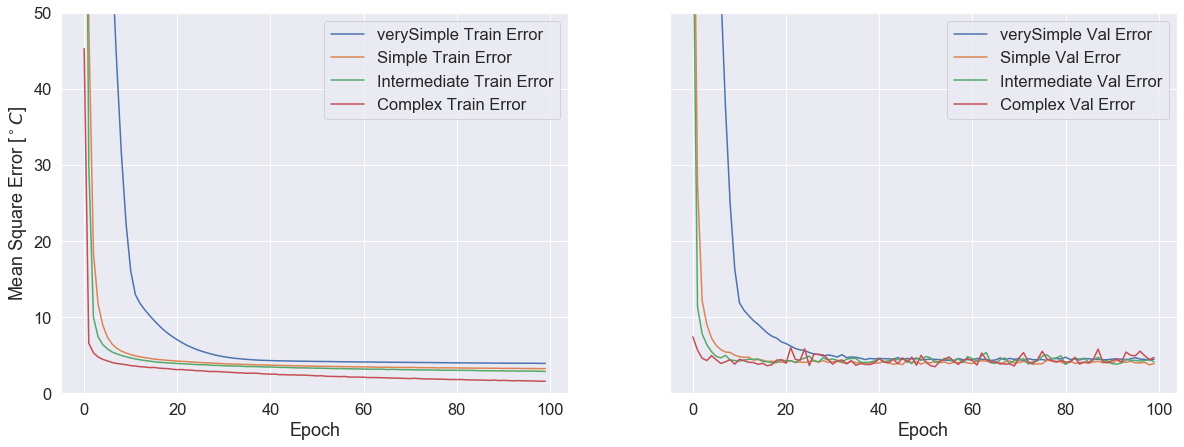

In [26]:
fig, ax = plt.subplots(1,2, figsize = (20,7), sharey=True)

ax[0].plot(verySimplehist['epoch'], verySimplehist['mse'], label='verySimple Train Error')
ax[1].plot(verySimplehist['epoch'], verySimplehist['val_mse'], label = 'verySimple Val Error')

ax[0].plot(Simplehist['epoch'], Simplehist['mse'], label='Simple Train Error')
ax[1].plot(Simplehist['epoch'], Simplehist['val_mse'], label = 'Simple Val Error')

ax[0].plot(Intermediatehist['epoch'], Intermediatehist['mse'], label='Intermediate Train Error')
ax[1].plot(Intermediatehist['epoch'], Intermediatehist['val_mse'], label = 'Intermediate Val Error')

ax[0].plot(Complexhist['epoch'], Complexhist['mse'], label='Complex Train Error')
ax[1].plot(Complexhist['epoch'], Complexhist['val_mse'], label = 'Complex Val Error')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Mean Square Error [$^\circ C$]')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim([0,50])
plt.show()

In [28]:
rf_test_vars_tmin_norm = preprocessing.scale(rf_test_vars_tmin)
tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model_verySimple.predict(rf_test_vars_tmin_norm), squared=False)
print('verySimple RMSE on test set: {}'.format(round(tmin_rmse, 3)))

tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model_Simple.predict(rf_test_vars_tmin_norm), squared=False)
print('Simple RMSE on test set: {}'.format(round(tmin_rmse, 3)))

tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model_Intermediate.predict(rf_test_vars_tmin_norm), squared=False)
print('Intermediate RMSE on test set: {}'.format(round(tmin_rmse, 3)))

tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model_Complex.predict(rf_test_vars_tmin_norm), squared=False)
print('Complex RMSE on test set: {}'.format(round(tmin_rmse, 3)))

verySimple RMSE on test set: 2.109
Simple RMSE on test set: 2.103
Intermediate RMSE on test set: 2.245
Complex RMSE on test set: 2.336


In [97]:
tmin_rmse = mean_squared_error(test_verification_tmin, 0.5*(tmin_model_Simple.predict(rf_test_vars_tmin_norm)
                                                            + tmin_model_verySimple.predict(rf_test_vars_tmin_norm)), squared=False)
print('verySimple RMSE on test set: {}'.format(round(tmin_rmse, 3)))

verySimple RMSE on test set: 2.064


### Refinement

In [123]:
def build_tmin_model_Complex_v2():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])], kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [124]:
tmin_model = build_tmin_model_Complex_v2()

In [125]:
tmin_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 20)                560       
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 21        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [126]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)

history = tmin_model.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback])
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 5s 2ms/sample - loss: 104.2785 - mae: 8.3989 - mse: 102.1087 - val_loss: 59.7287 - val_mae: 6.4320 - val_mse: 57.5129
Epoch 2/100
2631/2631 [==============================] - 1s 297us/sample - loss: 41.1212 - mae: 4.8879 - mse: 38.8686 - val_loss: 16.3825 - val_mae: 3.0067 - val_mse: 14.1186
Epoch 3/100
2631/2631 [==============================] - 1s 289us/sample - loss: 28.9929 - mae: 4.0315 - mse: 26.7421 - val_loss: 14.4439 - val_mae: 2.9061 - val_mse: 12.2124
Epoch 4/100
2631/2631 [==============================] - 1s 266us/sample - loss: 25.5197 - mae: 3.7311 - mse: 23.2996 - val_loss: 11.2379 - val_mae: 2.3674 - val_mse: 9.0360
Epoch 5/100
2631/2631 [==============================] - 1s 296us/sample - loss: 23.6189 - mae: 3.5545 - mse: 21.4387 - val_loss: 11.8729 - val_mae: 2.5813 - val_mse: 9.7100
Epoch 6/100
2631/2631 [==============================] - 1s 295us/sample - loss:

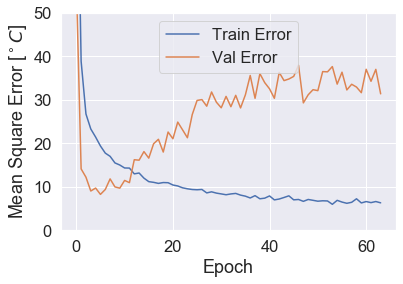

In [127]:
plot_history('$^\circ C$')

In [128]:
rf_test_vars_tmin_norm = preprocessing.scale(rf_test_vars_tmin)
tmin_rmse = mean_squared_error(test_verification_tmin, tmin_model.predict(rf_test_vars_tmin_norm), squared=False)
print('RMSE on test set: {}'.format(round(tmin_rmse, 3)))

RMSE on test set: 5.948


### Ensemble

In [129]:
def build_tmin_model_variable(n_nodes):
    model = keras.Sequential([
        Dense(n_nodes, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [133]:
# Build each model
for nodes in range(4,31):
    globals()['tmin_model_' + str(nodes)] = build_tmin_model_variable(nodes)

In [134]:
# Example
tmin_model_4.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 4)                 112       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [144]:
def train_tmin_model(model_nodes):
    logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)
    
    model = globals()['tmin_model_' + str(model_nodes)]

    globals()['tmin_model_' + str(model_nodes) + '_history'] = model.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=100, validation_split = 0.1, callbacks=[early_stop, tensorboard_callback], verbose=0.)
    globals()['tmin_model_' + str(model_nodes) + 'hist'] = pd.DataFrame(globals()['tmin_model_' + str(model_nodes) + '_history'].history)
    globals()['tmin_model_' + str(model_nodes) + 'hist']['epoch'] = globals()['tmin_model_' + str(model_nodes) + '_history'].epoch

In [145]:
# Train each model
for nodes in range(4,31):
    print('Training model ' + str(nodes) + '...')
    train_tmin_model(nodes)

Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 10...
Training model 11...
Training model 12...
Training model 13...
Training model 14...
Training model 15...
Training model 16...
Training model 17...
Training model 18...
Training model 19...
Training model 20...
Training model 21...
Training model 22...
Training model 23...
Training model 24...
Training model 25...
Training model 26...
Training model 27...
Training model 28...
Training model 29...
Training model 30...


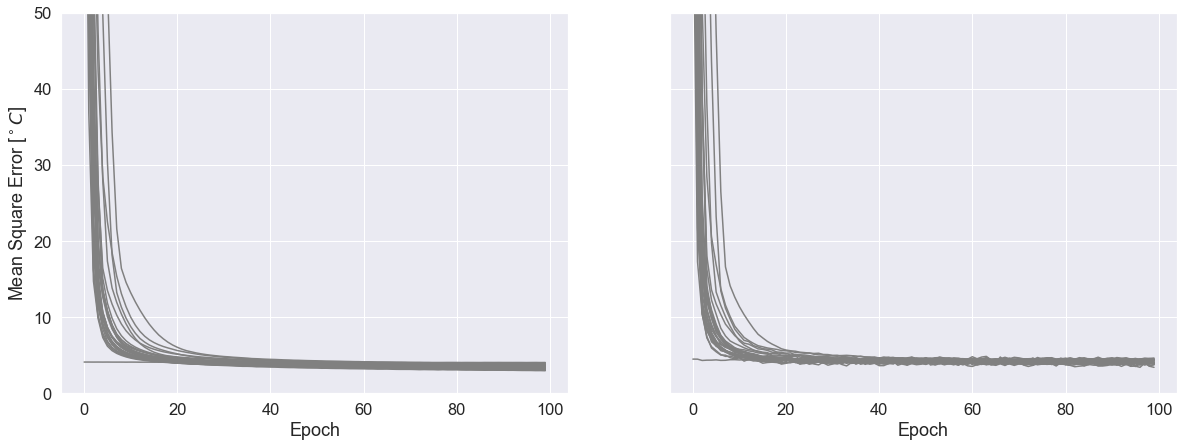

In [147]:
# Show histories
def plot_history(model_nodes, train_axis, val_axis):
    hist = globals()['tmin_model_' + str(model_nodes) + 'hist']
    train_axis.plot(hist['epoch'], hist['mse'], color = 'gray')
    val_axis.plot(hist['epoch'], hist['val_mse'], color = 'gray')
    
fig, ax = plt.subplots(1,2, figsize = (20,7), sharey=True)

for nodes in range(4,31):
    plot_history(nodes, ax[0], ax[1])

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Mean Square Error [$^\circ C$]')
ax[0].set_ylim([0,50])
plt.show()

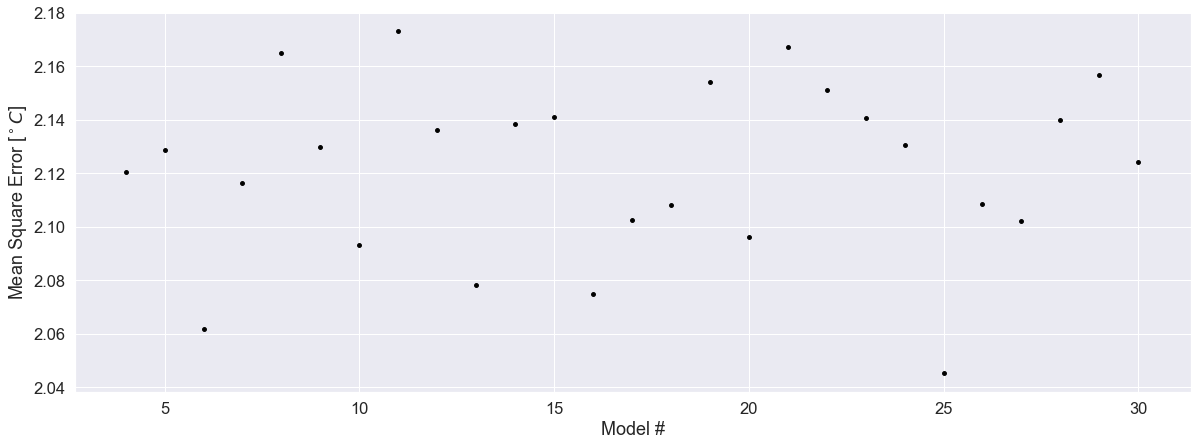

In [153]:
# RMSEs
fig, ax = plt.subplots(1,1, figsize = (20,7))

for nodes in range(4,31):
    model = globals()['tmin_model_' + str(nodes)]
    rmse = mean_squared_error(test_verification_tmin, model.predict(rf_test_vars_tmin_norm), squared=False)
    ax.scatter(nodes, rmse, s=15, c='black')

ax.set_xlabel('Model #')
ax.set_ylabel('Mean Square Error [$^\circ C$]')
plt.show()

In [160]:
# Ensemble RMSE
prediction = 0.

for nodes in range(4,31):
    model = globals()['tmin_model_' + str(nodes)]
    prediction += model.predict(rf_test_vars_tmin_norm)

prediction /= 26.

print('Ensemble Mean RMSE: ' + str(np.round(mean_squared_error(test_verification_tmin, prediction, squared=False),4)) + ' deg C')

Ensemble Mean RMSE: 2.0233 deg C


In [164]:
# Ensemble RMSE
prediction = 0.

for nodes in [6,16,25]:
    model = globals()['tmin_model_' + str(nodes)]
    prediction += model.predict(rf_test_vars_tmin_norm)

prediction /= 3.

print('Ensemble Mean RMSE: ' + str(np.round(mean_squared_error(test_verification_tmin, prediction, squared=False),4)) + ' deg C')

Ensemble Mean RMSE: 2.0116 deg C


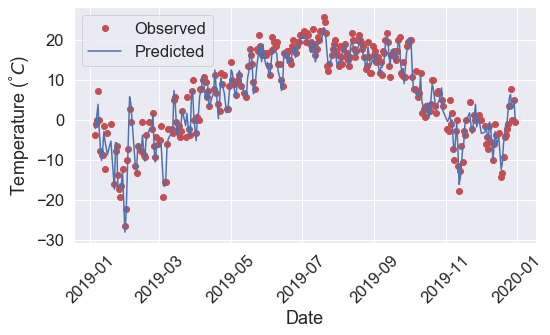

In [165]:
# Plot 
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, prediction, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Max Wind Speed

In [102]:
rf_train_vars_wind

array([[-1.01600000e+01, -1.59600000e+01,  4.68721666e+00, ...,
         2.01000000e+03,  1.00000000e+00,  2.00000000e+00],
       [-9.96000000e+00, -1.43600000e+01,  5.94138031e+00, ...,
         2.01000000e+03,  1.00000000e+00,  3.00000000e+00],
       [-8.46000000e+00, -1.28600000e+01,  5.68506816e+00, ...,
         2.01000000e+03,  1.00000000e+00,  4.00000000e+00],
       ...,
       [ 1.34400000e+01,  5.04000000e+00,  1.02883429e+01, ...,
         2.01800000e+03,  1.20000000e+01,  2.60000000e+01],
       [ 1.11400000e+01,  4.00000000e-02,  7.99061950e+00, ...,
         2.01800000e+03,  1.20000000e+01,  2.70000000e+01],
       [ 1.74000000e+00, -2.66000000e+00,  5.00099990e+00, ...,
         2.01800000e+03,  1.20000000e+01,  2.80000000e+01]])

In [103]:
# Standardize
rf_train_vars_wind_norm = preprocessing.scale(rf_train_vars_wind)

In [104]:
rf_train_vars_wind_norm

array([[-2.32891796, -2.30849916, -0.44270535, ..., -1.4602298 ,
        -1.61253656, -1.5548518 ],
       [-2.31115791, -2.14857422,  0.09056833, ..., -1.4602298 ,
        -1.61253656, -1.44113527],
       [-2.17795748, -1.9986446 , -0.01841627, ..., -1.4602298 ,
        -1.61253656, -1.32741875],
       ...,
       [-0.23323133, -0.20948443,  1.93890825, ...,  1.60626589,
         1.62118287,  1.17434479],
       [-0.43747197, -0.70924984,  0.96191022, ...,  1.60626589,
         1.62118287,  1.28806132],
       [-1.27219462, -0.97912316, -0.3092839 , ...,  1.60626589,
         1.62118287,  1.40177784]])

### Model

In [119]:
# Build model
def build_wind_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_wind_norm[0])]),
        Dense(1, activation=tf.nn.relu)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [120]:
wind_model = build_wind_model()

In [121]:
wind_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 20)                1800      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 21        
Total params: 1,821
Trainable params: 1,821
Non-trainable params: 0
_________________________________________________________________


In [122]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = wind_model.fit(rf_train_vars_wind_norm, train_verification_wind, epochs=100, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 5s 2ms/sample - loss: 32.5079 - mae: 4.9547 - mse: 32.5079 - val_loss: 17.2582 - val_mae: 3.3407 - val_mse: 17.2582
Epoch 2/100
2631/2631 [==============================] - 1s 322us/sample - loss: 12.8022 - mae: 2.8662 - mse: 12.8022 - val_loss: 8.9556 - val_mae: 2.3208 - val_mse: 8.9556
Epoch 3/100
2631/2631 [==============================] - 1s 339us/sample - loss: 7.6724 - mae: 2.2088 - mse: 7.6724 - val_loss: 6.3840 - val_mae: 1.9344 - val_mse: 6.3840
Epoch 4/100
2631/2631 [==============================] - 1s 359us/sample - loss: 5.6871 - mae: 1.9003 - mse: 5.6871 - val_loss: 4.7936 - val_mae: 1.6620 - val_mse: 4.7936
Epoch 5/100
2631/2631 [==============================] - 1s 359us/sample - loss: 4.6088 - mae: 1.7032 - mse: 4.6088 - val_loss: 4.6178 - val_mae: 1.6263 - val_mse: 4.6178
Epoch 6/100
2631/2631 [==============================] - 1s 360us/sample - loss: 3.9748 - mae:

### RMSE

In [123]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 1.675


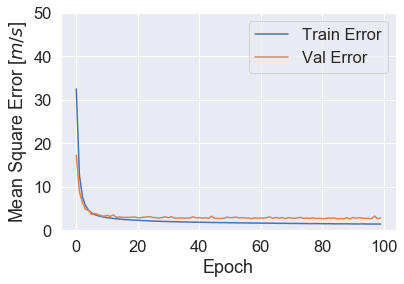

In [124]:
plot_history('$m/s$')

In [125]:
rf_test_vars_wind_norm = preprocessing.scale(rf_test_vars_wind)
wind_rmse = mean_squared_error(test_verification_wind, wind_model.predict(rf_test_vars_wind_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(wind_rmse, 3)))

Root Mean Square Error on test set: 1.709


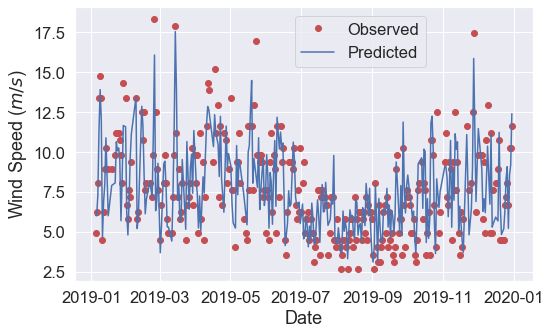

In [146]:
# Plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, wind_model.predict(rf_test_vars_wind_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Total Precipitation

In [23]:
rf_train_vars_prcp.head()

,RTOT,TMAX,TMIN,WMAX,tmpc,mslp,skct,day,Min MCLD(%),Max MCLD(%),...,Max 500hPa WSPD(m/s),Max 925hPa WSPD(m/s),Avg 850hPa WSPD(m/s),Avg 500hPa WSPD(m/s),Avg 250hPa DWPDEP(C),Avg 500hPa DWPDEP(C),Min 500hPa DWPDEP(C),Avg 700hPa DWPDEP(C),Min 700hPa DWPDEP(C),Avg 850hPa DWPDEP(C)
0,0.00,-10.16,-15.96,4.687217,-13.325000,1029.316667,2.250000,2,0.0,1.0,...,81.098451,28.288681,23.064628,71.364032,12.923575,22.132323,12.601770,25.793559,17.745552,15.539375
1,0.06,-9.96,-14.36,5.941380,-16.525000,1032.991667,0.000000,3,0.0,1.0,...,53.195702,14.984583,14.311850,44.387013,13.530215,10.528838,7.183483,28.465952,16.835678,19.689315
2,0.17,-8.46,-12.86,5.685068,-15.325000,1032.250000,0.000000,4,0.0,96.0,...,35.140197,22.735308,19.625230,25.397043,12.685044,10.415984,3.023898,7.769617,2.909177,11.441479
3,0.77,-7.16,-11.06,3.794733,-14.441667,1028.141667,1.333333,5,0.0,67.0,...,28.346544,20.754109,19.975509,23.702333,8.908692,11.261288,3.546582,10.463400,3.958006,10.031624
4,7.10,-5.46,-7.46,9.548298,-15.133333,1026.608333,3.333333,6,0.0,100.0,...,44.823732,14.102946,12.570186,35.073703,7.681385,10.312995,2.920655,13.015104,1.089298,14.460429


In [24]:
# Standardize
rf_train_vars_prcp_norm = preprocessing.scale(rf_train_vars_prcp)

In [25]:
rf_train_vars_prcp_norm

array([[-0.46509258, -2.32891796, -2.30849916, ...,  1.52496059,
         1.79890333,  0.96575738],
       [-0.45659356, -2.31115791, -2.14857422, ...,  1.86209646,
         1.66155774,  1.59753526],
       [-0.44101203, -2.17795748, -1.9986446 , ..., -0.74885119,
        -0.44064974,  0.34190254],
       ...,
       [ 0.9429114 , -0.23323133, -0.20948443, ..., -0.17088529,
        -0.64149051,  0.08255837],
       [-0.43959552, -0.43747197, -0.70924984, ..., -0.05455181,
        -0.84780538, -1.17994507],
       [-0.46509258, -1.27219462, -0.97912316, ...,  1.03412771,
         1.74979727, -0.73029968]])

### Model

In [147]:
# Build model
def build_prcp_model():
    model = keras.Sequential([
        Dense(4, activation=tf.nn.relu, input_shape=[len(rf_train_vars_prcp_norm[0])]),
        Dense(1, activation=tf.nn.relu)
    ])

    model.compile(optimizer = tf.optimizers.RMSprop(),
                  # tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
                  # There are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

In [148]:
prcp_model = build_prcp_model()

In [149]:
prcp_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 4)                 104       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 5         
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


In [150]:
%%time

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# early_stop = keras.callbacks.EarlyStopping(monitor='mse', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = prcp_model.fit(rf_train_vars_prcp_norm, train_verification_prcp, epochs=100, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/100
2631/2631 [==============================] - 6s 2ms/sample - loss: 37.2222 - mae: 2.1361 - mse: 37.2222 - val_loss: 53.6576 - val_mae: 2.5651 - val_mse: 53.6576
Epoch 2/100
2631/2631 [==============================] - 1s 334us/sample - loss: 34.8598 - mae: 2.1518 - mse: 34.8598 - val_loss: 50.3063 - val_mae: 2.5976 - val_mse: 50.3063
Epoch 3/100
2631/2631 [==============================] - 1s 335us/sample - loss: 32.5595 - mae: 2.2065 - mse: 32.5595 - val_loss: 47.9435 - val_mae: 2.6669 - val_mse: 47.9435
Epoch 4/100
2631/2631 [==============================] - 1s 313us/sample - loss: 31.0769 - mae: 2.2812 - mse: 31.0769 - val_loss: 46.2103 - val_mae: 2.7291 - val_mse: 46.2103
Epoch 5/100
2631/2631 [==============================] - 1s 289us/sample - loss: 30.0442 - mae: 2.3399 - mse: 30.0442 - val_loss: 45.0456 - val_mae: 2.7785 - val_mse: 45.0456
Epoch 6/100
2631/2631 [==============================] - 1s 334us/sample - loss:

### RMSE

In [151]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 6.698


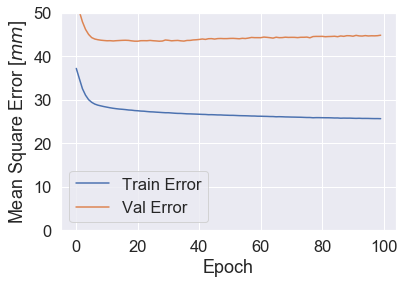

In [152]:
plot_history('$mm$')

In [153]:
rf_test_vars_prcp_norm = preprocessing.scale(rf_test_vars_prcp)
prcp_rmse = mean_squared_error(test_verification_prcp, prcp_model.predict(rf_test_vars_prcp_norm), squared=False)
print('Root Mean Square Error on test set: {}'.format(round(prcp_rmse, 3)))

Root Mean Square Error on test set: 4.306


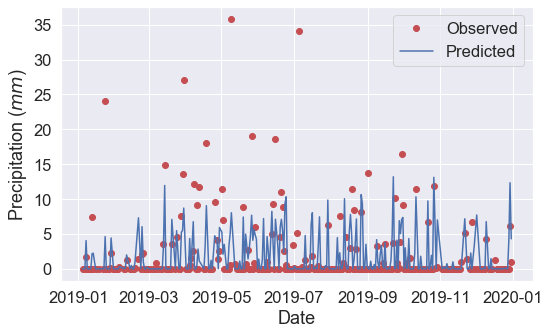

In [154]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, prcp_model.predict(rf_test_vars_prcp_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()